# Previous code

In [109]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [3]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
# build vocabulary

chars = ["."] + sorted(list(set("".join(words))))
stoi = { s:i for i,s in enumerate(chars) } # string to integer
itos = { i:s for s,i in stoi.items() } # integer to string

In [21]:
context_length = 8

In [22]:
def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * context_length
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [23]:
# build training, dev, test sets

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


# Initial code

In [24]:
# define layers

class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
  
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps # to avoid divisionbyzero error when scaling
    self.momentum = momentum # to compute running average
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (stored with a running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    # update the bufers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]
  
class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []
  
class Embedding:
    def __init__(self, vocab_size, embed_dim):
        self.weight = torch.randn((vocab_size, embed_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [42]:
# model setup

n_embed = 10
n_hidden = 200
vocab_size = 27

model = Sequential([
  Embedding(vocab_size, n_embed),
  Flatten(),
  Linear(n_embed * context_length, n_hidden), Tanh(),
  Linear(                n_hidden, vocab_size)
])

with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].weight *= 0.1
  # # all other layers: apply gain
  # for layer in model.layers[:-1]:
  #   if isinstance(layer, Linear):
  #     layer.weight *= 5/3 # only because we are using tanh

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

21897


In [43]:
# training

max_steps = 30_000
batch_size = 128

for i in range(1, max_steps+1):
  # construct minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  # track stats
  if i % 10_000 == 0 or i == 1:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

  break

      1/  30000: 3.3149


In [45]:
# inference

for layer in model.layers:
    layer.training = False

@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

In [47]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * context_length
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the "." token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

tbscrqxbzbpqnyruurqwyyygjokiwuhzyxd.
crrrjmzttabvkxnyankcvpgxouqz.
meqoliavqvilrhuywoenmmzkrzachbzctha.
kzvouaytwvqmgvcrwirxirufp.
ehl.
hdkcig.
tmhxynwwyabywaqvvpjfpczgsvxs.
trz.
aduhmypoztoypdedpdsqrzznnh.
iyst.
acfczayi.
znpkqavmetbgthdnnjjavfhgtnbmiimpdm.
epydfflicx.
hnmgizurejykxtzkvsxdeteqiq.
eailzrdzjcismgfstfffiajdspibawfinlmfankbdwigcpyya.
xyjcmngymzpc.
asahnlaqgdwfjwlnbr.
dbja.
iosbuqypjohnnufyoveyaofrxbdcdtgulbfznywqnlcoczjqltrkjbdjydtnpdvxcrlmy.
bsyxujfbhxtfbnjmvwzyyttmblbfkr.


# Testing

In [48]:
ix = torch.randint(0, Xtr.shape[0], (4,))
ix

tensor([170447,  68828, 160348, 156382])

In [49]:
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 13, 15, 14, 18, 15],
        [ 0,  0,  0,  0,  0,  0, 13, 21],
        [ 0,  0,  0,  0,  0,  0, 23, 15],
        [ 0,  0,  0,  0, 20,  5, 14,  9]])

In [50]:
model.layers[0].out.shape # Embedding

torch.Size([4, 8, 10])

In [51]:
model.layers[1].out.shape # Flatten

torch.Size([4, 80])

In [52]:
model.layers[2].out.shape # Linear

torch.Size([4, 200])

In [59]:
(torch.randn((4, 80)) @ torch.randn((80, 200)) + torch.randn(200)).shape

torch.Size([4, 200])

In [54]:
(torch.randn((4, 5, 80)) @ torch.randn((80, 200)) + torch.randn(200)).shape

torch.Size([4, 5, 200])

In [60]:
t1 = torch.tensor(
                   [[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [9, 10, 11, 12]]) # (3, 4)

t2 = torch.tensor([[1, 2, 3, 4, 5],
                   [6, 7, 8, 9, 10],
                   [11, 12, 13, 14, 15],
                   [16, 17, 18, 19, 20]]) # (4, 5)

t3 = t1 @ t2
print(t3.shape)
t3

torch.Size([3, 5])


tensor([[110, 120, 130, 140, 150],
        [246, 272, 298, 324, 350],
        [382, 424, 466, 508, 550]])

In [58]:
t1 = torch.tensor([

                   [[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [9, 10, 11, 12]],

                   [[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [9, 10, 11, 12]]
                   
                   ]) # (2, 3, 4)

t2 = torch.tensor([[1, 2, 3, 4, 5],
                   [6, 7, 8, 9, 10],
                   [11, 12, 13, 14, 15],
                   [16, 17, 18, 19, 20]]) # (4, 5)

t3 = t1 @ t2
print(t3.shape)
t3

torch.Size([2, 3, 5])


tensor([[[110, 120, 130, 140, 150],
         [246, 272, 298, 324, 350],
         [382, 424, 466, 508, 550]],

        [[110, 120, 130, 140, 150],
         [246, 272, 298, 324, 350],
         [382, 424, 466, 508, 550]]])

In [61]:
tb = torch.tensor(
    [
        [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]],
        [[13, 14, 15], [16, 17, 18], [19, 20, 21], [22, 23, 24]],
        [[25, 26, 27], [28, 29, 30], [31, 32, 33], [34, 35, 36]]
    ]
)

tb.shape # (batch, context, embed)

torch.Size([3, 4, 3])

In [63]:
# concatenate each consecutive embedding

tb_nxt = tb.view(tb.shape[0], tb.shape[1]//2, -1)
tb_nxt

tensor([[[ 1,  2,  3,  4,  5,  6],
         [ 7,  8,  9, 10, 11, 12]],

        [[13, 14, 15, 16, 17, 18],
         [19, 20, 21, 22, 23, 24]],

        [[25, 26, 27, 28, 29, 30],
         [31, 32, 33, 34, 35, 36]]])

In [64]:
tb_nxt.shape # (batch, context/2, embed*2)

torch.Size([3, 2, 6])

# Wavenet

In [98]:
# define layers

class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
  
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps # to avoid divisionbyzero error when scaling
    self.momentum = momentum # to compute running average
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (stored with a running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate forward pass
    if self.training:
      if x.ndim == 2:
         dim_reduce = 0
      elif x.ndim == 3:
         dim_reduce = (0, 1)
      xmean = x.mean(dim_reduce, keepdim=True) # batch mean
      xvar = x.var(dim_reduce, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    # update the bufers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]
  
class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []
  
class Embedding:
    def __init__(self, vocab_size, embed_dim):
        self.weight = torch.randn((vocab_size, embed_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n):
       self.n = n

    def __call__(self, x):
        B, T, C = x.shape # B = batch, T = time or context window, C = channels or embed dim
        x = x.view(B, T//self.n, C*self.n)
        # if we have a spurious dimension, then squeeze it out
        if x.shape[1] == 1:
           x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [118]:
# model setup

n_embed = 24
n_hidden = 128
vocab_size = 27

model = Sequential([
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

76579


In [119]:
# training

max_steps = 40_000
batch_size = 32
lossi = []

for i in range(1, max_steps+1):
  # construct minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 30_000 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  # track stats
  if i % 10_000 == 0 or i == 1:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.item())

      1/  40000: 3.3076
  10000/  40000: 2.6019
  20000/  40000: 2.9917
  30000/  40000: 1.8765
  40000/  40000: 2.0409


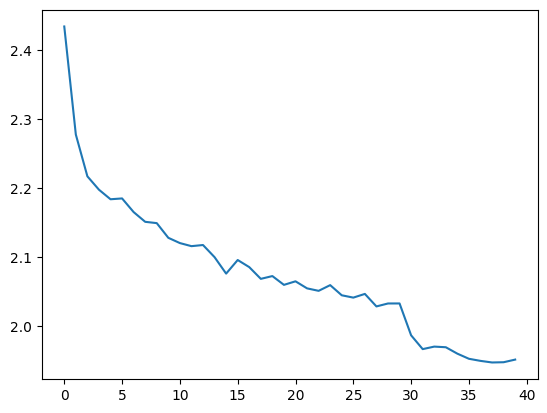

In [125]:
avg_lossi = torch.tensor(lossi).view(-1, 1000).mean(1)
plt.plot(range(len(avg_lossi)), avg_lossi)

In [126]:
# inference

for layer in model.layers:
    layer.training = False

@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 1.9291411638259888
val 2.0126211643218994


In [127]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (22767, 8, 24)
FlattenConsecutive : (22767, 4, 48)
Linear : (22767, 4, 128)
BatchNorm1d : (22767, 4, 128)
Tanh : (22767, 4, 128)
FlattenConsecutive : (22767, 2, 256)
Linear : (22767, 2, 128)
BatchNorm1d : (22767, 2, 128)
Tanh : (22767, 2, 128)
FlattenConsecutive : (22767, 256)
Linear : (22767, 128)
BatchNorm1d : (22767, 128)
Tanh : (22767, 128)
Linear : (22767, 27)


In [128]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * context_length
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the "." token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

krisde.
heneen.
mila.
jariyah.
weloric.
karalyn.
casni.
urtae.
arkier.
aniara.
alexand.
olsarsy.
hinnatia.
shenan.
camyah.
kydin.
vinnlisha.
limone.
riora.
maho.
